# **Momentum variance of heavy quarks immersed in the Glasma**

Default simulation parameters chosen for Pb-Pb at 5.02 TeV.


In [1]:
import numpy as np

# General parameters
su_group = 'su3'        # Gauge group
folder = 'trial_su3_corr'      # Results folder

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_s = 2.0     # Simulation time [fm/c]
DTS = 8     # Time step

# MV model parameters for Pb-Pb at 5.02 TeV
A = 207     # Mass number
sqrts = 5020        # Center-of-mass energy [GeV]
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         # Saturation momentum [GeV]	
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
m = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

# Heavy quark related parameters, chosen here for a charm quark
mass = 1.5      # Heavy quark mass [GeV]
tau_form = 0.06     # Formation time [fm/c]
nq = 15     # Number of heavy quarks
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 10    # Number of test particles

# Other numerical parameters
nevents = 10    # Number of Glasma events
interp = 'no'     # Interpolate fields or use nearest lattice points
solveq = 'wilson lines'     # Solve the equation for the color charge with Wilson lines or gauge potentials

Dictionary with standard MV model paramaters.

In [2]:
p = {
    # General parameters
    'GROUP':    su_group,       # SU(2) or SU(3) group
    'FOLDER':   folder,         # results folder

    # Parameters for simulation box
    'L':    L,           # transverse size [fm]
    'N':    N,            # lattice size
    'DTS':  DTS,             # time steps per transverse spacing
    'TMAX': tau_s,          # max. proper time (tau) [fm/c]

    # Parameters for MV model
    'G':    g,            # YM coupling constant
    'MU':   mu,             # MV model parameter [GeV]
    'M':    m,              # IR regulator [GeV]
    'UV':   uv,           # UV regulator [GeV]
    'NS':   ns,             # number of color sheets
    
    # Parameters for heavy quarks
    'MASS': mass,           # mass of HQ [GeV]
    'TFORM': tau_form,       # formation time of the HQ [fm/c]
    'PT': pT,           # transverse momentum of HQs [GeV]
    'NQ': nq,         # number of heavy quarks
    'NTP': ntp,         # number of test particles

    # Numerical parameters
    'NEVENTS': nevents,     # number of Glasma events
    'INTERP': interp,       # interpolate fields or use nearest lattice points
    'SOLVEQ': solveq,       # method used to solve the equation for color charge
}

if p['SOLVEQ']=='wilson lines':
    p['INTERP']='no'
NUM_CHECKS = True

Set environment variables.

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
if p['GROUP'] == 'su2':
    os.environ["GAUGE_GROUP"] = 'su2_complex'
elif p['GROUP'] == 'su3':
    os.environ["GAUGE_GROUP"] = p['GROUP']

# Import curraun and other packages
import sys
sys.path.append('..')
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda
from curraun.wong_hq import WongFields, ColorChargeWilsonLines, WongPotentials, ColorChargeGaugePotentials, initial_coords, initial_momenta, initial_charge, interpfield, interppotential, update_coords, update_momenta

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using CUDA
Using SU(3)
Using double precision
Using double precision


Simulation function.

In [4]:
def simulate(p, xmu0, pmu0, q0, seed):    
    # Derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    p['E0'] = E0
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a * p['DTS'])
    formt = int(p['TFORM'] / a * p['DTS'])
    mass = p['MASS']

    # Normal units: x/y [fm], eta [1], px/py [GeV], peta [GeV/fm]
    # Lattice units
    x0, y0, eta0 = xmu0[0]/a, xmu0[1]/a, xmu0[2]
    ptau0, px0, py0, peta0 = pmu0[0]/E0, pmu0[1]/E0, pmu0[2]/E0, pmu0[3]*a/E0

    s = core.Simulation(p['N'], DT, p['G'])
    mv.set_seed(seed)
    va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
    initial.init(s, va, vb)

    fields = WongFields(s)
    if p['SOLVEQ']=='gauge potentials':
        potentials = WongPotentials(s)  

    if use_cuda:
        s.copy_to_device()

    output = {}
    output['xmu'], output['pmu'] = [], []
    if NUM_CHECKS:
        output['constraint'], output['casimirs'] = [], []

    for t in range(maxt):
        core.evolve_leapfrog(s)

        if t>=formt:  
            current_tau = t * DT
            tau_step = DT
            
            if t==formt:
                output['xmu'].append([a*current_tau, a*x0, a*y0, eta0])
                output['pmu'].append([E0*ptau0, E0*px0, E0*py0, E0/a*peta0])

                if p['SOLVEQ']=='gauge potentials':
                    charge = ColorChargeGaugePotentials(s, q0)
                else:
                    charge = ColorChargeWilsonLines(s, q0)
                    xhq0, yhq0 = int(round(x0)), int(round(y0))

                Q0 = charge.Q
                if NUM_CHECKS:
                    C = charge.C.real
                    if p['GROUP']=='su2':
                        output['casimirs'].append(C[0])
                    elif p['GROUP']=='su3':
                        output['casimirs'].append([C[0], C[1]])

            # Solve Wong's equations using basic Euler
            # Update positions
            x1, y1, eta1 = update_coords(x0, y0, eta0, ptau0, px0, py0, peta0, tau_step)

            # Convert to physical units
            output['xmu'].append([a*current_tau, a*x1, a*y1, eta1])

            if p['INTERP']=='yes':                
                trQE_interp, trQB_interp = interpfield(x0, y0, Q0, fields)
                Ax_interp, Ay_interp, Aeta_interp = interppotential(x0, y0, 'x', potentials), interppotential(x0, y0, 'y', potentials), interppotential(x0, y0, 'eta', potentials)

                # Update momenta using Euler, with interpolated fields
                ptau1, ptau2, px1, py1, peta1 = update_momenta(ptau0, px0, py0, peta0, tau_step, current_tau, trQE_interp, trQB_interp, mass, E0)

                # Convert to physical units
                output['pmu'].append([E0*ptau1, E0*px1, E0*py1, E0/a*peta1])
                if NUM_CHECKS:
                    output['constraint'].append(E0*(ptau2-ptau1))

                charge.evolve(Q0, tau_step, ptau0, px0, py0, peta0, Ax_interp, Ay_interp, Aeta_interp)
                Q1 = charge.Q 
                if NUM_CHECKS:
                    C = charge.C.real
                    if p['GROUP']=='su2':
                        output['casimirs'].append(C[0])
                    elif p['GROUP']=='su3':
                        output['casimirs'].append([C[0], C[1]])

            else:
                # Approximate the position of the quark with closest lattice point
                # Locations where transverse gauge fields extracted from gauge links are evaluated, in the middle of lattice sites
                xhq, yhq = int(round(x0)), int(round(y0))

                fields.compute(Q0, xhq, yhq)
                trQE, trQB = fields.trQE.real, fields.trQB.real

                if p['SOLVEQ']=='gauge potentials':
                    xahq, yahq = int(round(x0-1/2)), int(round(y0-1/2))
                    potentials.compute('x', xahq, yhq)
                    Ax = potentials.Ax
                    potentials.compute('y', xhq, yahq)
                    Ay = potentials.Ay
                    potentials.compute('eta', xhq, yhq)
                    Aeta = potentials.Aeta

                # Update momenta using Euler, with fields evaluated at nearest lattice points
                ptau1, ptau2, px1, py1, peta1 = update_momenta(ptau0, px0, py0, peta0, tau_step, current_tau, trQE, trQB, mass, E0)

                # Convert to physical units
                output['pmu'].append([E0*ptau1, E0*px1, E0*py1, E0/a*peta1])
                if NUM_CHECKS:
                    output['constraint'].append(E0*(ptau2-ptau1))

                if p['SOLVEQ']=='gauge potentials':
                    charge.evolve(Q0, tau_step, ptau0, px0, py0, peta0, Ax, Ay, Aeta)
                else:
                    delta_etahq = eta1-eta0
                    charge.evolve(xhq, xhq0, yhq, yhq0, delta_etahq)
                    if (xhq!=xhq0):
                        xhq0=xhq
                    if (yhq!=yhq0):
                        yhq0=yhq

                Q1 = charge.Q
                if NUM_CHECKS:
                    C = charge.C.real
                    if p['GROUP']=='su2':
                        output['casimirs'].append(C[0])
                    elif p['GROUP']=='su3':
                        output['casimirs'].append([C[0], C[1]])

            # Swap initial x, p, Q for next time step
            x0, y0, eta0 = x1, y1, eta1
            px0, py0, peta0, ptau0 = px1, py1, peta1, ptau1
            Q0 = Q1

    if use_cuda:
        s.copy_to_host()
        cuda.current_context().deallocations.clear()

    return output

Create folders to store the files resulting from the simulations


In [5]:
import pickle

current_path = os.getcwd() 
results_folder = 'results'
check_results_folder = os.path.isdir(results_folder)
if not check_results_folder:
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'
os.chdir(results_path)

wong_folder = p['FOLDER']
check_wong_folder = os.path.isdir(wong_folder)
if not check_wong_folder:
    os.makedirs(wong_folder)
wong_path = results_path + '/' + wong_folder + '/'
os.chdir(wong_path)

# Save parameters dictionary to file
# with open('parameters.pickle', 'wb') as handle:
#     pickle.dump(p, handle)

Simulate multiple Glasma events, each event with 15 quarks and 15 antiquarks, produced at the same positions as the quarks, having opposite momenta and random charge. The number of quarks or antiquarks in enlarged by a given number of test particles.


In [ ]:
# from tqdm import tnrange
from tqdm.notebook import tqdm

# Initializing progress bar objects
# Source: https://stackoverflow.com/questions/60928718/python-how-to-replace-tqdm-progress-bar-by-next-one-in-nested-loop
outer_loop=tqdm(range(p['NEVENTS']), desc="Event", position=0)
mid_loop=tqdm(range(p['NQ']), desc="Quark antiquark pair", position=1)
inner_loop=tqdm(range(p['NTP']), desc="Test particle", position=2)


for ev in range(len(outer_loop)):
    # Fixing the seed in a certain event
    seed = ev

    mid_loop.refresh() 
    mid_loop.reset() 
    outer_loop.update() 

    for q in range(len(mid_loop)):
        inner_loop.refresh()  
        inner_loop.reset()  
        mid_loop.update()  

        for tp in range(len(inner_loop)):
            xmu0 = initial_coords(p)
            pmu0 = initial_momenta(p)

            # Quark
            q0 = initial_charge(p)

            filename = 'ev_' + str(ev+1) + '_q_' + str(q+1) + '_tp_' + str(tp+1) + '.pickle'
            output = simulate(p, xmu0, pmu0, q0, seed)
            with open(filename, 'wb') as handle:
                pickle.dump(output, handle)

            # Antiquark having opposite momentum and random color charge
            q0 = initial_charge(p)
            pmu0 = [pmu0[0], -pmu0[1], -pmu0[2], pmu0[3]]

            filename = 'ev_' + str(ev+1) + '_aq_' + str(q+1) + '_tp_' + str(tp+1) + '.pickle'
            output = simulate(p, xmu0, pmu0, q0, seed)
            with open(filename, 'wb') as handle:
                pickle.dump(output, handle)

            inner_loop.update()   

Read the results from files and compute averages.

In [6]:
def average(wong_path):
    average = {}
    x, y = [], []
    px, py = [], []

    taui = 0

    for file in os.listdir(wong_path):
        if file.startswith("ev_"):
            data = pickle.load(open(file, 'rb'))
            x.append(np.array(data['xmu'])[:, 1])
            y.append(np.array(data['xmu'])[:, 2])
            px.append(np.array(data['pmu'])[:, 1])
            py.append(np.array(data['pmu'])[:, 2])

            if taui==0:
                average['tau']=np.array(data['xmu'])[:, 0]
                taui = taui+1

    time_steps = np.array(px).shape[1]

    sigmaxt, sigmapt = [], []

    for i in range(1, time_steps):
        sigmaxt.append(((np.array(x)[:, i]-np.array(x)[:, 0]) ** 2+(np.array(y)[:, i]-np.array(y)[:, 0]) ** 2)/2)
        sigmapt.append(((np.array(px)[:, i]-np.array(px)[:, 0]) ** 2+(np.array(py)[:, i]-np.array(py)[:, 0]) ** 2)/2)

    average['sigmaxt_mean'], average['sigmaxt_std'] = np.mean(sigmaxt, axis=1), np.std(sigmaxt, axis=1)
    average['sigmapt_mean'], average['sigmapt_std'] = np.mean(sigmapt, axis=1), np.std(sigmapt, axis=1)

    filename = 'avg.npz'
    with open(filename, 'wb') as handle:
        pickle.dump(average, handle)

check_file_avg = os.path.isfile('avg.npz')
if not check_file_avg:
    average(wong_path)
data = pickle.load(open('avg.npz', 'rb'))
sigmaxt_mean, sigmaxt_std, sigmapt_mean, sigmapt_std, tau = data['sigmaxt_mean'], data['sigmaxt_std'], data['sigmapt_mean'], data['sigmapt_std'], data['tau']

Plot the momentum variance.

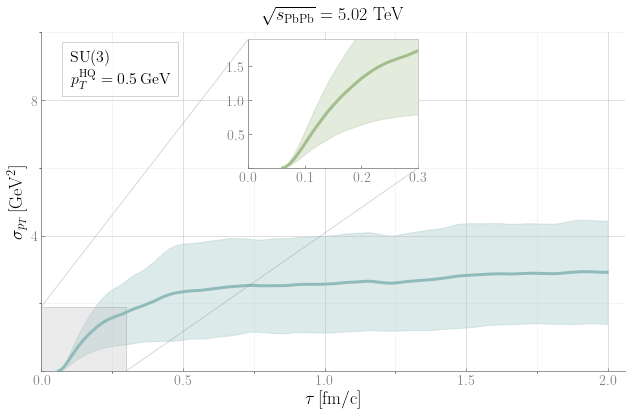

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.rcParams['text.usetex'] = True
plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams.update({'font.size':14})

fig = plt.figure()
ax = plt.subplot(111)

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)
figure_title = r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}$'
plt.text(0.5, 1.04, figure_title, horizontalalignment='center', fontsize=18, transform = ax.transAxes)

ax.set_xlim(0,2.06)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'silver', linestyle = '-', linewidth = 1, alpha=0.5)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
plt.grid(b=True, which='minor', color='silver', alpha=0.2)

ax.plot(tau[1:len(tau)], sigmapt_mean, '-', color = '#8FBCBB', markersize = 0, linewidth = 3)
ax.fill_between(tau[1:len(tau)], sigmapt_mean-sigmapt_std/2, sigmapt_mean+sigmapt_std/2, color = '#8FBCBB', alpha=0.3)

axins = zoomed_inset_axes(ax,2,loc='upper center')
axins.spines['top'].set_color('silver')
axins.spines['right'].set_color('silver')
axins.spines['bottom'].set_color('gray')
axins.spines['left'].set_color('gray') 
axins.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)

axins.yaxis.get_major_ticks()[1].label1.set_visible(False)
axins.plot(tau[1:len(tau)], sigmapt_mean, '-', color = '#A3BE8C', markersize = 0, linewidth = 3)
axins.fill_between(tau[1:len(tau)], sigmapt_mean-sigmapt_std/2, sigmapt_mean+sigmapt_std/2, color = '#A3BE8C', alpha=0.3)

if p['GROUP']=='su2':
    ax.set_ylim(0,3.5)
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    axins.xaxis.set_major_locator(MultipleLocator(0.1))
    axins.yaxis.set_major_locator(MultipleLocator(0.2))
    x1,x2,y1,y2 = 0, 0.3, 0, 0.65
    textstr = '\n'.join((
    r'$\mathrm{SU}(2)$',
    r'$p_T^{\mathrm{HQ}}=0.5\,\mathrm{GeV}$',
    ))
elif p['GROUP']=='su3':
    ax.set_ylim(0,10.0)
    ax.yaxis.set_major_locator(MultipleLocator(4))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    axins.xaxis.set_major_locator(MultipleLocator(0.1))
    axins.yaxis.set_major_locator(MultipleLocator(0.5))
    x1,x2,y1,y2 = 0, 0.3, 0, 1.9
    textstr = '\n'.join((
    r'$\mathrm{SU}(3)$',
    r'$p_T^{\mathrm{HQ}}=0.5\,\mathrm{GeV}$',
    ))

axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)

mark_inset(ax,axins,loc1=2,loc2=4, color='gray', alpha=0.3, fc='silver')


props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

plt.tight_layout()

os.chdir(current_path)
# plt.savefig('plots/sigmapT' + '_' + wong_folder + '.png', dpi=300, facecolor='white', transparent=False)
plt.show()

Plot the variance in positions.

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
# plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{x_T}\,\mathrm{[fm^2]}$', size = 18)

ax.set_xlim(0,2.06)
ax.set_ylim(0,1.0)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.yaxis.get_major_ticks()[0].label1.set_visible(False)
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

ax.plot(tau[1:len(tau)], sigmaxt_mean, '-', color = '#B48EAD', markersize = 0, linewidth = 3)
ax.fill_between(tau[1:len(tau)], sigmaxt_mean-sigmaxt_std/2, sigmaxt_mean+sigmaxt_std/2, color = '#B48EAD', alpha=0.3)

textstr = '\n'.join((
    r'$p_T=0.5\,\mathrm{GeV}$',
    r'$\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$',
    ))
props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.savefig('plots/sigmaxT' + '_' + su_group + '_pT_' + str(pT) +'_pb+pb_5020gev_q2_1.5.png', dpi = 300, facecolor='white', transparent=False)
plt.show()

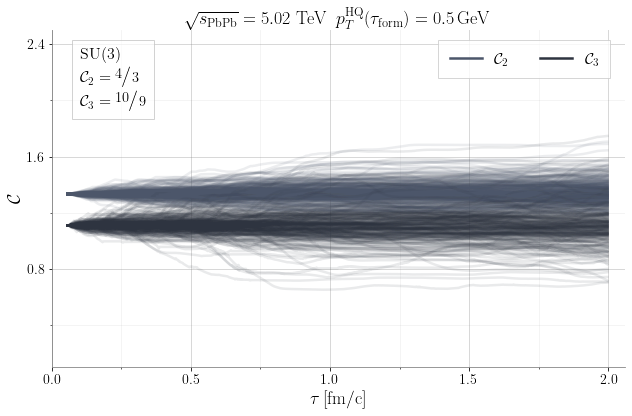

In [8]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage{xfrac}']

fig = plt.figure()
ax = plt.subplot(111)

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\mathcal{C}$', size = 18)

ax.set_xlim(0,2.06)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

Nc = core.su.NC

if su_group=='su2':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,p_T^{\mathrm{HQ}}(\tau_\mathrm{form})=0.5\,\mathrm{GeV}$', size = 18)

    ax.set_ylim(0.7,0.8)

    # ax.yaxis.set_major_locator(MultipleLocator(0.04))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.02))

    textstr = '\n'.join((
        r'${\huge\mathrm{SU(2)}}$',
        r'$\mathcal{C}_2={\huge\sfrac{3}{\,4}}$',
    ))

    pltcolorc2 = '#4C566A'

elif su_group=='su3':
    plt.title(r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\,\mathrm{TeV}\,\,\,p_T^{\mathrm{HQ}}(\tau_\mathrm{form})=0.5\,\mathrm{GeV}$', size = 18)

    ax.set_ylim(0.1, 2.5)

    ax.yaxis.set_major_locator(MultipleLocator(0.8))
    ax.yaxis.set_minor_locator(MultipleLocator(0.4))

    textstr = '\n'.join((
        r'${\huge\mathrm{SU(3)}}$',
        r'$\mathcal{C}_2={\huge\sfrac{4}{\,3}}$',
        r'$\mathcal{C}_3={\huge\sfrac{10}{\,9}}$',
    ))

    pltcolorc2, pltcolorc3 = '#4C566A', '#2E3440'

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.3)
ax.xaxis.grid(True, which='minor')
ax.yaxis.grid(True, which='minor')
plt.grid(b=True, which='minor', color='gray', alpha=0.1)


taui = 0
for file_name in os.listdir(wong_path):
    if file_name.startswith('ev_'):
        file_path = wong_path + file_name
        data = pickle.load(open(file_path, 'rb'))
        qsq = np.array(data['casimirs'])
        if taui==0:
            tau = np.array(data['xmu'])[:, 0]
            taui = taui+1
            if su_group=='su3':
                plt.plot(tau, -1*qsq[:, 0], '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, label=r'$\mathcal{C}_2$')
                plt.plot(tau, -1*qsq[:, 1], '-', color = pltcolorc3, markersize = 0, linewidth = 2.5, label=r'$\mathcal{C}_3$')
        if su_group=='su2':
            plt.plot(tau, qsq, '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, alpha=0.2)
        elif su_group=='su3':
            plt.plot(tau, qsq[:, 0], '-', color = pltcolorc2, markersize = 0, linewidth = 2.5, alpha=0.1)
            plt.plot(tau, qsq[:, 1], '-', color = pltcolorc3, markersize = 0, linewidth = 2.5, alpha=0.1)

props = dict(boxstyle='square', facecolor='white', alpha=0.7, edgecolor='silver', pad=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=16, verticalalignment='top', bbox=props)

if su_group=='su3':
    leg = ax.legend(fontsize = 16, loc = 'upper right', ncol=2, bbox_to_anchor=(0.98,0.98))
    leg.get_frame().set_boxstyle('square')

plt.tight_layout()
# plt.savefig('plots/' + wong_folder + '.png', dpi = 300, facecolor='white', transparent=False)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(3)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\delta p^\tau/p^\tau\,(\%)$', size = 18)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

taui = 0
for file_name in os.listdir(wong_path):
    if file_name.startswith('ev_1'):
        file_path = wong_path + file_name
        data = pickle.load(open(file_path, 'rb'))
        delta_ptau = data['constraint']
        ptau = np.array(data['pmu'])[:, 0]
        deltaptau_ptau = np.divide(delta_ptau, ptau[1:len(ptau)])
        if taui==0:
            tau = np.array(data['xmu'])[:, 0]
            taui = taui+1
        plt.plot(tau[1:len(tau)], deltaptau_ptau, '-', color = 'gray', markersize = 0, linewidth = 2.5, alpha=0.1)

plt.tight_layout()
plt.savefig('plots/ptau_constraint_' + wong_folder + '.png', dpi = 300, facecolor='white', transparent=False)
plt.show()

In [ ]:
pTs = [0.5, 5.0, 10.0]
sigmapt_mean, sigmapt_std = {}, {}

for pT in pTs:
    wong_folder = 'pb+pb_5020gev_su2_pT_' + str(pT) + '_charm'
    wong_path = results_path + wong_folder + '/' 
    os.chdir(wong_path)
    check_file_avg = os.path.isfile('avg.npz')
    if not check_file_avg:
        average(wong_path)
    data = pickle.load(open('avg.npz', "rb"))
    sigmapt_mean[str(pT)], sigmapt_std[str(pT)], tau = data['sigmapt_mean'], data['sigmapt_std'], data['tau']

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)

ax.set_xlim(0,2.06)
ax.set_ylim(0,3.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

colors = ['#8FBCBB', '#A3BE8C', '#EBCB8B']
pTs = [0.5, 5.0, 10.0]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

i = 0
for pT in pTs:
    ax.plot(tau[1:len(tau)], sigmapt_mean[str(pT)], '-', color = colors[i], markersize = 0, linewidth = 3, label=labels[i])
    ax.fill_between(tau[1:len(tau)], sigmapt_mean[str(pT)]-sigmapt_std[str(pT)]/2, sigmapt_mean[str(pT)]+sigmapt_std[str(pT)]/2, color = colors[i], alpha=0.2)
    i=i+1

leg = ax.legend(fontsize = 16, loc = 'upper left')
leg.get_frame().set_boxstyle('square')
leg.set_title(r'$p_T\,\mathrm{[GeV]}$',prop={'size':18})

plt.tight_layout()
os.chdir(current_path)
# plt.savefig('plots/sigmapT_comp_' + '_' + wong_folder + '.png', dpi = 300, facecolor='white', transparent=False)
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.subplot(111)
plt.title(r'$\mathrm{Pb+Pb}\,\,\, 5.02\,\,\mathrm{TeV}\,\,\,\mathrm{SU(2)}$', size = 18)
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', size = 18)
plt.ylabel(r'$\sigma_{p_T}\,\mathrm{[GeV^2]}$', size = 18)

ax.set_xlim(0,2.06)
ax.set_ylim(0,1.5)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray') 
ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
# ax.tick_params(direction='in', colors='gray',grid_color='gray', grid_alpha=0.5)
plt.grid(color = 'gray', linestyle = '-', linewidth = 1, alpha=0.2)

folders = ['pb+pb_5020gev_su2_pT_0.5_charm', 'pb+pb_5020gev_su2_pT_0.5_gauge_potentials_charm', 'pb+pb_5020gev_su2_pT_0.5_lab_charm']
colors = ['#8FBCBB', '#A3BE8C', '#A3BE8C']
labels = [r'$\mathrm{Wilson\,lines\,in\,}\mathcal{MF}$', r'$\mathrm{Gauge\,potentials\,in\,}\mathcal{MF}$', r'$\mathrm{Wilson\,lines\,in\,}\mathcal{LF}$']
i=0

for wong_folder in folders:
    wong_path = results_path + wong_folder + '/' 
    os.chdir(wong_path)
    check_file_avg = os.path.isfile('avg.npz')
    if not check_file_avg:
        average(wong_path)
    data = pickle.load(open('avg.npz', "rb"))
    sigmapt_mean[str(pT)], sigmapt_std[str(pT)], tau = data['sigmapt_mean'], data['sigmapt_std'], data['tau']

    ax.plot(tau[1:len(tau)], sigmapt_mean[str(pT)], '-', color = colors[i], markersize = 0, linewidth = 3, label=labels[i])
    # ax.fill_between(tau[1:len(tau)], sigmapt_mean[str(pT)]-sigmapt_std[str(pT)]/2, sigmapt_mean[str(pT)]+sigmapt_std[str(pT)]/2, color = colors[i], alpha=0.2)
    i=i+1

leg = ax.legend(fontsize = 16, loc = 'upper left')
leg.get_frame().set_boxstyle('square')
# leg.set_title(r'$\mathrm{Method\,to\,solve\,Q}$',prop={'size':18})

plt.tight_layout()
os.chdir(current_path)
# plt.savefig('plots/sigmapT_comp_' + '_' + wong_folder + '.png', dpi = 300, facecolor='white', transparent=False)
plt.show()